# Molybdän-Spektrum
## Mit LiF-Kristall

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

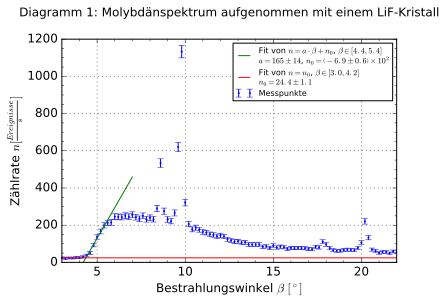

In [9]:
import uncertainties as uc
import uncertainties.unumpy as un
from scipy.optimize import curve_fit
import scipy.constants as c

d = 201.4e-12
U_B = 35e+3

data1a = pd.read_csv("255\\1a_MoSpek_LiF.txt", sep="\t", decimal=',', header=None)
b = data1a[0].values
n = data1a[1].values
n = un.uarray(n, sqrt(n))
# display(data1a)

f_U = lambda b,n: b-b+n
s_U = slice(0,7)
poptU, pcovU = curve_fit(f_U, b[s_U], un.nominal_values(n[s_U]), sigma=un.std_devs(n[s_U]))
n_U = uc.ufloat(poptU[0], sqrt(pcovU[0][0]))

s = ( (n <= 200) & ( (b <= 6) | (n <= 45) ) ) & (n > 30)

f_lin = lambda x, m, n0: m*x+n0

popt, pcov = curve_fit(f_lin, b[s], un.nominal_values(n[s]), sigma=un.std_devs(n[s]))
m = uc.ufloat(popt[0], sqrt(pcov[0][0]))
n0 = uc.ufloat(popt[1], sqrt(pcov[1][1]))

b_G = (n_U-n0)/m
y_G = 2*d*un.sin(b_G/360*2*pi)

h = c.e * y_G * U_B / c.c

display(Latex(r"$\beta_{{Grenz}} = {:L}°$".format(b_G)))
display(Latex(r"$\lambda_{{Grenz}} = {:L}pm$".format(y_G*10**12)))
display(Latex(r"$h = {:L}Js$".format(h)))
display(Latex(r"$\beta_2  = {:L}°$".format(un.arcsin(y_G/d)/2/pi*360)))

x_ = linspace(4,7,100)
x_U = linspace(b[0],b[-1],100)
figure()
errorbar(b, un.nominal_values(n), yerr=un.std_devs(n), marker='.', ls='none', label="Messpunkte")
plot(x_, f_lin(x_,*popt), label="Fit von $n=a \cdot \\beta + n_0$, $\\beta \\in [{0},{1}]$\n$a={2:L}$, $n_0={3:L}$".format(b[s][0],b[s][-1], m, n0))
plot(x_U, f_U(x_U,n_U.n), label="Fit von $n=n_0$, $\\beta \\in [{0},{1}]$\n$n_0={2:L}$".format(b[s_U][0],b[s_U][-1], n_U))
xlim((3,22))
ylim((0,1200))
xlabel(r"Bestrahlungswinkel $\beta \ [^\circ]$")
ylabel(r"Zählrate $n [\frac{Ereignisse}{s}]$")
# yscale('log')
minorticks_on()
grid()
legend(fontsize=8)
title(r"Diagramm 1: Molybdänspektrum aufgenommen mit einem LiF-Kristall", y=1.08, fontsize=12)
show()

## $K_{\alpha}$ und $K_{\beta}$

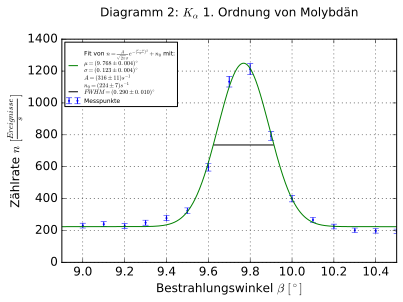

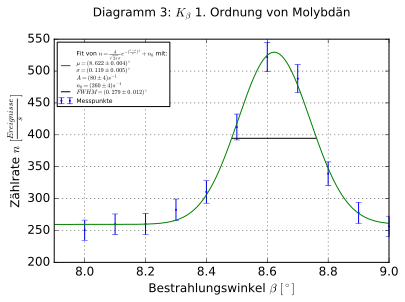

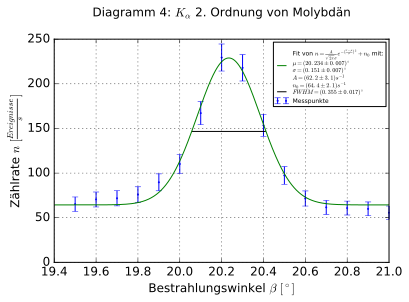

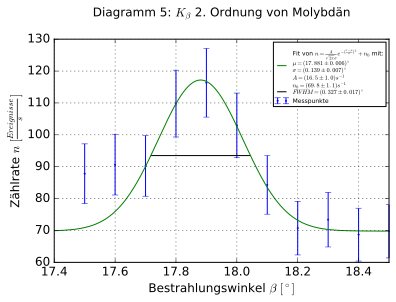

,Bestrahlungswinkel $\beta \ [^\circ]$,$\lambda \ [pm]$
$K_{\alpha}$ 1. Ordnung,$9.77 \pm 0.12$,$68.3 \pm 0.9$
$K_{\beta}$ 1. Ordnung,$8.62 \pm 0.12$,$60.4 \pm 0.8$
$K_{\alpha}$ 2. Ordnung,$20.23 \pm 0.15$,$69.7 \pm 0.5$
$K_{\beta}$ 2. Ordnung,$17.88 \pm 0.14$,$61.8 \pm 0.5$


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [13]:
dataK = [
    loadtxt("255\\1b_Ka1_LiF.txt").transpose(),
    loadtxt("255\\1b_Kb1_LiF.txt").transpose(),
    loadtxt("255\\1b_Ka2_LiF.txt").transpose(),
    loadtxt("255\\1b_Kb2_LiF.txt").transpose()
]
b = array([dataK[0][0], dataK[1][0], dataK[2][0], dataK[3][0]])
n = array([dataK[0][1], dataK[1][1], dataK[2][1], dataK[3][1]])
dn = array([sqrt(i) for i in n])

f_Gauss = lambda x, m, s, A, n0: A/(sqrt(2*pi)*s) * exp(-1/2 * ((x-m)/s)**2) + n0
labels = ["$K_{{\\alpha}}$ {}. Ordnung","$K_{{\\beta}}$ {}. Ordnung"]

y = [[],[]]
bL = []
for i in range(4):
    if i==3:
        b_ = b[i]
        b[i] = b[i][2:]
        n_ = n[i]
        n[i] = n[i][2:]
        dn_ = dn[i]
        dn[i] = dn[i][2:]
    popt, pcov = curve_fit(f_Gauss, b[i], n[i], sigma=dn[i],
                           p0=[b[i][0]+(b[i][-1]-b[i][0])/2, (b[i][-1]-b[i][0])/4, sum(n[i]), n[i][0]])
    
    popt = un.uarray(popt, sqrt(diagonal(pcov)))
    
    if i==3:
        b[i] = b_
        n[i] = n_
        dn[i] = dn_
    
    x_  = linspace(b[i][0]-0.1,b[i][-1],1000)
    
    FWHM = 2*sqrt(2*log(2))*popt[1]
    
    figure()
    grid()
    xlabel(r"Bestrahlungswinkel $\beta \ [^\circ]$")
    ylabel(r"Zählrate $n \ [\frac{Ereignisse}{s}]$")
    errorbar(b[i], n[i], yerr=dn[i], marker='.', ls='none', label=r"Messpunkte")
    hlines(popt[3].n + (f_Gauss(x_,*un.nominal_values(popt)).max()-popt[3].n)/2, popt[0].n-FWHM.n/2, popt[0].n+FWHM.n/2,
          label="$FWHM=({:L})^{{\circ}}$".format(FWHM))
    plot(x_, f_Gauss(x_,*un.nominal_values(popt)), 
         label="Fit von $n = \\frac{{A}}{{\\sqrt{{2 \\pi}} \\sigma}} e^{{-\\left( \\frac{{x- \\mu}}{{\\sigma}} \\right)^2}}+n_0$ mit:\n"
        +"$\mu =({0:L})^{{\circ}}$\n$\sigma =({1:L})^{{\circ}}$\n$A=({2:L})s^{{-1}}$\n$n_0 = ({3:L})s^{{-1}}$".format(*popt))
    xlim((b[i][0]-0.1,b[i][-1]))
    title(r"Diagramm {0}: {1} von Molybdän".format(i+2,labels[i%2].format(i//2+1)), y=1.08, fontsize=12)
    if i>1:
        legend(loc=1,fontsize=6)
    else: legend(loc=2,fontsize=6)
    show()
    
    b_L = uc.ufloat(popt[0].n, abs(popt[1].n))
    bL.append(b_L)
    y[i%2].append(2*d*un.sin(b_L/360*2*pi)/(i//2 + 1))
    
table_y = ["<h3>Tabelle 1: Linien der K-Serie von Molybdän, aufgenommen mit LiF-Kristall</h3>","<tr><th></th><th>Bestrahlungswinkel $\\beta \ [^\circ]$</th><th>$\\lambda \ [pm]$</th></tr>"]
for i in range(4):
    table_y.append("<tr><th>{0}</th><td>${1:L}$</td><td>${2:L}$</td></tr>".format(labels[i%2].format(i//2+1),bL[i],y[i%2][i//2]/c.pico))
display(HTML('<table>{}</table>'.format("".join(table_y))))

display(HTML("<h3>Mittelwerte</h3>"))
display(Latex(r"$K_{{\alpha}}=({:L})pm$".format((y[0][0]+y[0][1])/2/c.pico)))
display(Latex(r"$K_{{\beta}}=({:L})pm$".format(mean(y,axis=1)[1]/c.pico)))

## Einsatzspannung

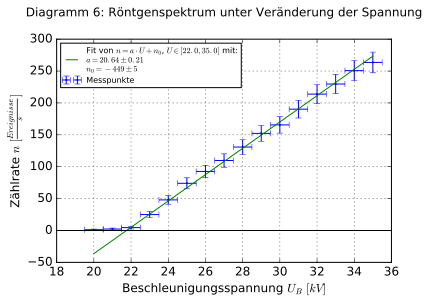

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [15]:
U, n = loadtxt("255\\1c_Span_LiF.txt", skiprows=1, unpack=True)
U = un.uarray(U,0.5)
n = un.uarray(n,sqrt(n))

f_lin = lambda U, a, n0: a*U+n0

sl = slice(2, None)

popt, pcov = curve_fit(f_lin, un.nominal_values(U[sl]), un.nominal_values(n[sl]), sigma=un.std_devs(n[sl]))
popt = un.uarray(popt, sqrt(diagonal(pcov)))

x_ = linspace(U[0].n,U[-1].n,100)
figure()
errorbar(un.nominal_values(U), un.nominal_values(n), xerr=un.std_devs(U), yerr=un.std_devs(n), fmt='.', label="Messpunkte")
plot(x_, f_lin(x_, *un.nominal_values(popt)), label="Fit von $n=a \cdot U + n_0$, $U \in [{2},{3}]$ mit:\n$a={0:L}$\n$n_0={1:L}$".format(*popt, U[sl][0].n,U[sl][-1].n))
ylim((-50,300))
axhline(0, color='black')
xlabel(r"Beschleunigungsspannung $U_B \ [kV]$")
ylabel(r"Zählrate $n \ [\frac{Ereignisse}{s}]$")
title(r"Diagramm 6: Röntgenspektrum unter Veränderung der Spannung", y=1.08, fontsize=12)
grid()
legend(loc=2, fontsize=8)
show()

U_E = -popt[1]/popt[0]
b = 7.5/360*2*pi
h = c.e * 2 * d * sin(b) * U_E*10**3 / c.c

display(Latex(r"$U_E=({:L})kV$".format(U_E)))
display(Latex(r"$h={:L}Js$".format(h)))

## Spektrum mit NaCl-Kristall

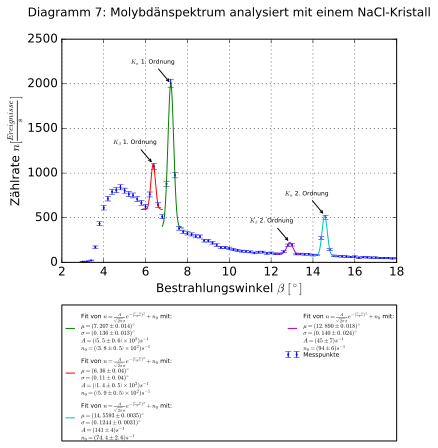

,Bestrahlungswinkel $\beta \ [^\circ]$,$a \ [pm]$
$K_{\alpha}$ 1. Ordnung,$7.21 \pm 0.14$,$545 \pm 12$
$K_{\beta}$ 1. Ordnung,$6.36 \pm 0.11$,$545 \pm 12$
$K_{\alpha}$ 2. Ordnung,$14.56 \pm 0.12$,$554 \pm 6$
$K_{\beta}$ 2. Ordnung,$12.89 \pm 0.14$,$554 \pm 7$


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [16]:
b, n = loadtxt("255\\2_MoSpek_NaCl.txt", unpack=True)
dn = sqrt(n)

figure()
title(r"Diagramm 7: Molybdänspektrum analysiert mit einem NaCl-Kristall", y=1.08, fontsize=12)
errorbar(b, n, yerr=dn, fmt='.', label="Messpunkte")

bounds = [(6.8, 7.9), (5.8, 6.9), (14, 15.3), (12.2, 13.5)]
sl = [((b >= i[0]) & (b <= i[1])) for i in bounds]

d_ = [[],[]]
bL_ = []
for i in range(4):
    popt, pcov = curve_fit(f_Gauss, b[sl[i]], n[sl[i]], sigma=dn[sl[i]],
                           p0=[b[sl[i]][0]+(b[sl[i]][-1]-b[sl[i]][0])/2, (b[sl[i]][-1]-b[sl[i]][0])/4, sum(n[sl[i]]), n[sl[i]][0]])
    popt = un.uarray(popt, sqrt(diagonal(pcov)))
    x_ = linspace(b[sl[i]][0], b[sl[i]][-1], 1000)
    plot(x_, f_Gauss(x_, *un.nominal_values(popt)),
         label="Fit von $n = \\frac{{A}}{{\\sqrt{{2 \\pi}} \\sigma}} e^{{-\\left( \\frac{{x- \\mu}}{{\\sigma}} \\right)^2}}+n_0$ mit:\n"
         +"$\mu =({0:L})^{{\circ}}$\n$\sigma =({1:L})^{{\circ}}$\n$A=({2:L})s^{{-1}}$\n$n_0 = ({3:L})s^{{-1}}$".format(*popt))
    annotate(labels[i%2].format(i//2+1), xy=(popt[0].n, f_Gauss(x_, *un.nominal_values(popt)).max()), fontsize=6, xycoords='data',
              xytext=(-40,20), textcoords='offset points',
              arrowprops=dict(arrowstyle="->"))
    b_L = uc.ufloat(popt[0].n, abs(popt[1].n))
    bL_.append(b_L)
    d_[i%2].append(y[i%2][i//2]/un.sin(b_L/360*2*pi)*(i//2 + 1))

xlabel(r"Bestrahlungswinkel $\beta \ [^\circ]$")
ylabel(r"Zählrate $n [\frac{Ereignisse}{s}]$")
legend(fontsize=6, bbox_to_anchor=(0., -.8, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
grid()
show()

table_d = ["<h3>Tabelle 2: Linien der K-Serie und Gitterkonstante von NaCl</h3>","<tr><th></th><th>Bestrahlungswinkel $\\beta \ [^\circ]$</th><th>$a \ [pm]$</th></tr>"]
for i in range(4):
    table_d.append("<tr><th>{0}</th><td>${1:L}$</td><td>${2:L}$</td></tr>".format(labels[i%2].format(i//2+1),bL_[i],d_[i%2][i//2]/c.pico))
display(HTML('<table>{}</table>'.format("".join(table_d))))
a = mean(d_)
display(Latex(r"$a_{{NaCl}}=({:L})pm$".format(a/c.pico)))
NA = 4*58.44/(2.164/c.centi**3)/a**3
display(Latex(r"$N_A={:L}$".format(NA)))